# TOG Attacks on YOLOv3 (Darknet53)

This jupyter notebook demonstrate the use of TOG attacks on one of the state-of-the-art object detection algorithms: You Only Look Once v3 (YOLOv3) proposed by Joseph Redmon [[link]](https://pjreddie.com/media/files/papers/YOLOv3.pdf). It has a Darknet53 backbone architecture. More details on the adversarial attacks can be found in the papers listed in the repository [[link]](https://github.com/git-disl/TOG).

## Preparation of Victim Detector

In [1]:
from dataset_utils.preprocessing import letterbox_image_padded
from misc_utils.visualization import visualize_detections
from keras import backend as K
from models.yolov3 import YOLOv3_Darknet53
from PIL import Image
from tog.attacks import *
import os
K.clear_session()

Using TensorFlow backend.
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

/usr/local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [ ]:
import streamlit as st

You can download the pretrained weights here [[link]](https://github.com/git-disl/TOG/releases/download/pm-v1.0/YOLOv3_Darknet53.h5) or use the popular repository implementing YOLOv3 in Keras [[link]](https://github.com/qqwweee/keras-yolo3) to train your own model. Once you have downloaded or trained the YOLOv3 detector, you need to *modify* the path in the cell below to point to the `.h5` file. 

In [ ]:
weights = 'model_weights/YOLOv3_Darknet53.h5'  # TODO: Change this path to the victim model's weights

detector = YOLOv3_Darknet53(weights=weights)

## Configuration of Attack Hyperparameters

In [ ]:
eps = 8 / 255.       # Hyperparameter: epsilon in L-inf norm
eps_iter = 2 / 255.  # Hyperparameter: attack learning rate
n_iter = 10          # Hyperparameter: number of attack iterations

We then load and visualize the image to be attacked using TOG algorithms.

In [ ]:
fpath = './assets/example_1.jpg'    # TODO: Change this path to the image to be attacked

input_img = Image.open(fpath)
x_query, x_meta = letterbox_image_padded(input_img, size=detector.model_img_size)
detections_query = detector.detect(x_query, conf_threshold=detector.confidence_thresh_default)
visualize_detections({'Benign (No Attack)': (x_query, detections_query, detector.model_img_size, detector.classes)})

## TOG-untargeted Attack

Random untargeted attacks fool the victim detector to randomly misdetect without targeting at any specific object. This class of attacks succeeds if the adversarial example fools the victim detector to give incorrect results of any form, such as having objects vanished, fabricated, or mislabeled randomly.

In [ ]:
# Generation of the adversarial example
x_adv_untargeted = tog_untargeted(victim=detector, x_query=x_query, n_iter=n_iter, eps=eps, eps_iter=eps_iter)

# Visualizing the detection results on the adversarial example and compare them with that on the benign input
detections_adv_untargeted = detector.detect(x_adv_untargeted, conf_threshold=detector.confidence_thresh_default)
visualize_detections({'Benign (No Attack)': (x_query, detections_query, detector.model_img_size, detector.classes),
                      'TOG-untargeted': (x_adv_untargeted, detections_adv_untargeted, detector.model_img_size, detector.classes)})

## TOG-vanishing Attack

Having a high recall to retrieve the objects in the input image is crucial in many applications. For instance, object detection has been applied in radiology to conduct automated breast cancer diagnosis, and positive detection alarms the patient to receive a further medical examination by a human expert. TOG-vanishing aims at removing the victim's ability to identify objects (i.e., adding false negatives). 

In [ ]:
# Generation of the adversarial example
x_adv_vanishing = tog_vanishing(victim=detector, x_query=x_query, n_iter=n_iter, eps=eps, eps_iter=eps_iter)

# Visualizing the detection results on the adversarial example and compare them with that on the benign input
detections_adv_vanishing = detector.detect(x_adv_vanishing, conf_threshold=detector.confidence_thresh_default)
visualize_detections({'Benign (No Attack)': (x_query, detections_query, detector.model_img_size, detector.classes),
                      'TOG-vanishing': (x_adv_vanishing, detections_adv_vanishing, detector.model_img_size, detector.classes)})

## TOG-fabrication Attack

Different from the above, the TOG-fabrication attack fabricates additional detections (i.e., adding false positives).

In [ ]:
x_adv_fabrication = tog_fabrication(victim=detector, x_query=x_query, n_iter=n_iter, eps=eps, eps_iter=eps_iter)

# Visualizing the detection results on the adversarial example and compare them with that on the benign input
detections_adv_fabrication = detector.detect(x_adv_fabrication, conf_threshold=detector.confidence_thresh_default)
visualize_detections({'Benign (No Attack)': (x_query, detections_query, detector.model_img_size, detector.classes),
                      'TOG-fabrication': (x_adv_fabrication, detections_adv_fabrication, detector.model_img_size, detector.classes)})

## TOG-mislabeling Attack

This attack consistently causes the victim detector to misclassify the objects detected on the input image by replacing their source class label with the maliciously chosen target class label, while maintaining the same set of correct bounding boxes. Such an attack can cause fatal collisions in many scenarios, e.g., misclassifying the stop sign as an umbrella. We can conduct the most-likely (ML) class attack by setting the attack targets to the incorrect class label with the highest probability predicted by the victim or the least-likely (LL) class attack with the lowest probability.

In [ ]:
# Generation of the adversarial examples
x_adv_mislabeling_ml = tog_mislabeling(victim=detector, x_query=x_query, target='ml', n_iter=n_iter, eps=eps, eps_iter=eps_iter)
x_adv_mislabeling_ll = tog_mislabeling(victim=detector, x_query=x_query, target='ll', n_iter=n_iter, eps=eps, eps_iter=eps_iter)

# Visualizing the detection results on the adversarial examples and compare them with that on the benign input
detections_adv_mislabeling_ml = detector.detect(x_adv_mislabeling_ml, conf_threshold=detector.confidence_thresh_default)
detections_adv_mislabeling_ll = detector.detect(x_adv_mislabeling_ll, conf_threshold=detector.confidence_thresh_default)
visualize_detections({'Benign (No Attack)': (x_query, detections_query, detector.model_img_size, detector.classes),
                      'TOG-mislabeling (ML)': (x_adv_mislabeling_ml, detections_adv_mislabeling_ml, detector.model_img_size, detector.classes),
                      'TOG-mislabeling (LL)': (x_adv_mislabeling_ll, detections_adv_mislabeling_ll, detector.model_img_size, detector.classes)})

# Streamlit Visualization 

Test section to use streamlit instead of jupyter notebook

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import ImageDraw, ImageFont

In [ ]:
def find_font_size(text, font, image, target_width_ratio):
    tested_font_size = 100
    tested_font = ImageFont.truetype(font, tested_font_size)
    observed_width, observed_height = get_text_size(text, image, tested_font)
    estimated_font_size = tested_font_size / (observed_width / image.width) * target_width_ratio
    return round(estimated_font_size)

def get_text_size(text, image, font):
    im = Image.new('RGB', (image.width, image.height))
    draw = ImageDraw.Draw(im)
    return draw.textsize(text, font)

In [ ]:
fpath = './assets/example_1.jpg'
uploaded_file
input_img = Image.open(fpath)
x_query, x_meta = letterbox_image_padded(input_img, size=detector.model_img_size)
detections_query = detector.detect(x_query, conf_threshold=detector.confidence_thresh_default)
# visualize_detections({'Benign (No Attack)': (x_query, detections_query, detector.model_img_size, detector.classes)})



In [ ]:
x_query.shape

In [ ]:
Image.fromarray((x_query.reshape(x_query.shape[1:])*255).astype(np.uint8))

In [ ]:
class AdversarialExample:
    def __init__(self,
                 title,
                 image):
        self.title = title
        self.image = image
    
    def streamlit_show(self, 
                       st_container):
        with st_container:
            st.title(self.title)
            st.image(self.image)
        

def draw_images_with_detections(detections_dict):
    colors = list(mcolors.CSS4_COLORS.values())
    images_dict = {}
    width_ratio = 0.2  # Portion of the image the text width should be (between 0 and 1)
    font_family = "arial.ttf"

    for pid, title in enumerate(detections_dict.keys()):
        input_img, detections, model_img_size, classes = detections_dict[title]
#         print((input_img.reshape(x_query.shape[1:])*255).astype(np.uint8))
        input_img = Image.fromarray((input_img.reshape(input_img.shape[1:])*255).astype(np.uint8))
        img_draw_context = ImageDraw.Draw(input_img)
        
        for box in detections:
            xmin = max(int(box[-4] * input_img.size[0]/ model_img_size[1]) , 0)
            ymin = max(int(box[-3] * input_img.size[1]/ model_img_size[1]) , 0)
            xmax = min(int(box[-2] * input_img.size[0]/ model_img_size[1]) , input_img.size[0])
            ymax = min(int(box[-1] * input_img.size[1]/ model_img_size[1]) , input_img.size[1])
            color = colors[int(box[0])]
            label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
            font_size = find_font_size(label, font_family, input_img, width_ratio)
            font = ImageFont.truetype(font_family, font_size)
            img_draw_context.rectangle(xy=[xmin, ymin, xmax, ymax], outline=color, width=4)
            img_draw_context.text(xy=[xmin, ymin], text=label, font=font)
        images_dict[title] = AdversarialExample(title=title, image=input_img)
    return images_dict

In [ ]:
fpath = './assets/example_1.jpg'
uploaded_file = Image.open(fpath)
x_query, x_meta = letterbox_image_padded(uploaded_file, size=detector.model_img_size)
detections_query = detector.detect(x_query, conf_threshold=detector.confidence_thresh_default)


In [ ]:
# x_adv_fabrication = tog_fabrication(victim=detector, x_query=x_query, n_iter=n_iter, eps=eps, eps_iter=eps_iter)
# x_adv_mislabeling_ml = tog_mislabeling(victim=detector, x_query=x_query, target='ml', n_iter=n_iter, eps=eps, eps_iter=eps_iter)
# x_adv_mislabeling_ll = tog_mislabeling(victim=detector, x_query=x_query, target='ll', n_iter=n_iter, eps=eps, eps_iter=eps_iter)
# x_adv_vanishing = tog_vanishing(victim=detector, x_query=x_query, n_iter=n_iter, eps=eps, eps_iter=eps_iter)
# x_adv_untargeted = tog_untargeted(victim=detector, x_query=x_query, n_iter=n_iter, eps=eps, eps_iter=eps_iter)



# # Visualizing the detection results on the adversarial examples and compare them with that on the benign input
detections_adv_fabrication = detector.detect(x_adv_fabrication, conf_threshold=detector.confidence_thresh_default)
detections_adv_mislabeling_ml = detector.detect(x_adv_mislabeling_ml, conf_threshold=detector.confidence_thresh_default)
detections_adv_mislabeling_ll = detector.detect(x_adv_mislabeling_ll, conf_threshold=detector.confidence_thresh_default)
detections_adv_untargeted = detector.detect(x_adv_untargeted, conf_threshold=detector.confidence_thresh_default)
detections_adv_vanishing = detector.detect(x_adv_vanishing, conf_threshold=detector.confidence_thresh_default)


tab_names = ['Original Image', 
            'Benign (No Attack)', 
            'TOG-fabrication', 
            'TOG-mislabeling (ML)',
            'TOG-mislabeling (LL)',
            'TOG-vanishing',
            'TOG-untargeted']
adversarial_detections_dicts = {tab_names[1]: (x_query, detections_query, detector.model_img_size, detector.classes),
                                tab_names[2]: (x_adv_fabrication, detections_adv_fabrication, detector.model_img_size, detector.classes),
                                tab_names[3]: (x_adv_mislabeling_ml, detections_adv_mislabeling_ml, detector.model_img_size, detector.classes),
                                tab_names[4]: (x_adv_mislabeling_ll, detections_adv_mislabeling_ll, detector.model_img_size, detector.classes),
                                tab_names[5]: (x_adv_vanishing, detections_adv_vanishing, detector.model_img_size, detector.classes),
                                tab_names[6]: (x_adv_untargeted, detections_adv_untargeted, detector.model_img_size, detector.classes)}                                      

drawn_images = draw_images_with_detections(adversarial_detections_dicts)


In [ ]:
tab_containers = st.tabs(tab_names)
drawn_images_dict = draw_images_with_detections(adversarial_detections_dicts)
drawn_images_dict[tab_names[0]] = AdversarialExample(title=tab_names[0],
                                                         image=uploaded_file)
for i, tab_name in enumerate(tab_names):
    tab_container = tab_containers[i]
    ad_sample = drawn_images_dict[tab_name].streamlit_show(tab_container)

In [ ]:
for i in drawn_images_dict.values():
    plt.figure()
    plt.imshow(i.image)

In [ ]:
# Generation of the adversarial examples

# Visualizing the detection results on the adversarial examples and compare them with that on the benign input
visualize_detections({'Benign (No Attack)': (x_query, detections_query, detector.model_img_size, detector.classes),
                      'TOG-mislabeling (ML)': (x_adv_mislabeling_ml, detections_adv_mislabeling_ml, detector.model_img_size, detector.classes),
                      'TOG-mislabeling (LL)': (x_adv_mislabeling_ll, detections_adv_mislabeling_ll, detector.model_img_size, detector.classes)})

In [ ]:
x_adv_fabrication = tog_fabrication(victim=detector, x_query=x_query, n_iter=n_iter, eps=eps, eps_iter=eps_iter)

# Visualizing the detection results on the adversarial example and compare them with that on the benign input
detections_adv_fabrication = detector.detect(x_adv_fabrication, conf_threshold=detector.confidence_thresh_default)
visualize_detections({'Benign (No Attack)': (x_query, detections_query, detector.model_img_size, detector.classes),
                      'TOG-fabrication': (x_adv_fabrication, detections_adv_fabrication, detector.model_img_size, detector.classes)})

In [ ]:
# Generation of the adversarial example
x_adv_vanishing = tog_vanishing(victim=detector, x_query=x_query, n_iter=n_iter, eps=eps, eps_iter=eps_iter)

# Visualizing the detection results on the adversarial example and compare them with that on the benign input
detections_adv_vanishing = detector.detect(x_adv_vanishing, conf_threshold=detector.confidence_thresh_default)
visualize_detections({'Benign (No Attack)': (x_query, detections_query, detector.model_img_size, detector.classes),
                      'TOG-vanishing': (x_adv_vanishing, detections_adv_vanishing, detector.model_img_size, detector.classes)})

In [ ]:
# Generation of the adversarial example
x_adv_untargeted = tog_untargeted(victim=detector, x_query=x_query, n_iter=n_iter, eps=eps, eps_iter=eps_iter)

# Visualizing the detection results on the adversarial example and compare them with that on the benign input
detections_adv_untargeted = detector.detect(x_adv_untargeted, conf_threshold=detector.confidence_thresh_default)
visualize_detections({'Benign (No Attack)': (x_query, detections_query, detector.model_img_size, detector.classes),
                      'TOG-untargeted': (x_adv_untargeted, detections_adv_untargeted, detector.model_img_size, detector.classes)})

<Figure size 432x288 with 0 Axes>

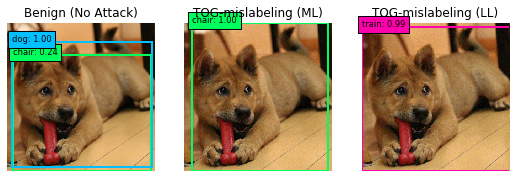

In [9]:
# Generation of the adversarial examples
x_adv_mislabeling_ml = tog_mislabeling(victim=detector, x_query=x_query, target='ml', n_iter=n_iter, eps=eps, eps_iter=eps_iter)
x_adv_mislabeling_ll = tog_mislabeling(victim=detector, x_query=x_query, target='ll', n_iter=n_iter, eps=eps, eps_iter=eps_iter)

# Visualizing the detection results on the adversarial examples and compare them with that on the benign input
detections_adv_mislabeling_ml = detector.detect(x_adv_mislabeling_ml, conf_threshold=detector.confidence_thresh_default)
detections_adv_mislabeling_ll = detector.detect(x_adv_mislabeling_ll, conf_threshold=detector.confidence_thresh_default)
visualize_detections({'Benign (No Attack)': (x_query, detections_query, detector.model_img_size, detector.classes),
                      'TOG-mislabeling (ML)': (x_adv_mislabeling_ml, detections_adv_mislabeling_ml, detector.model_img_size, detector.classes),
                      'TOG-mislabeling (LL)': (x_adv_mislabeling_ll, detections_adv_mislabeling_ll, detector.model_img_size, detector.classes)})

# Streamlit Visualization 

Test section to use streamlit instead of jupyter notebook

In [23]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import ImageDraw, ImageFont

In [80]:
def find_font_size(text, font, image, target_width_ratio):
    tested_font_size = 100
    tested_font = ImageFont.truetype(font, tested_font_size)
    observed_width, observed_height = get_text_size(text, image, tested_font)
    estimated_font_size = tested_font_size / (observed_width / image.width) * target_width_ratio
    return round(estimated_font_size)

def get_text_size(text, image, font):
    im = Image.new('RGB', (image.width, image.height))
    draw = ImageDraw.Draw(im)
    return draw.textsize(text, font)

In [21]:
fpath = './assets/example_1.jpg'
uploaded_file
input_img = Image.open(fpath)
x_query, x_meta = letterbox_image_padded(input_img, size=detector.model_img_size)
detections_query = detector.detect(x_query, conf_threshold=detector.confidence_thresh_default)
# visualize_detections({'Benign (No Attack)': (x_query, detections_query, detector.model_img_size, detector.classes)})



In [115]:
x_query.shape

(1, 416, 416, 3)

array([[[173, 141, 113],
        [184, 154, 124],
        [188, 156, 127],
        ...,
        [ 42,  31,  15],
        [ 47,  35,  19],
        [ 51,  37,  21]],

       [[178, 147, 114],
        [185, 156, 120],
        [189, 160, 125],
        ...,
        [ 42,  29,  16],
        [ 47,  34,  20],
        [ 50,  36,  23]],

       [[179, 149, 116],
        [186, 158, 119],
        [191, 163, 126],
        ...,
        [ 42,  29,  17],
        [ 47,  33,  20],
        [ 50,  36,  23]],

       ...,

       [[191, 157,  97],
        [194, 159,  97],
        [197, 162, 100],
        ...,
        [222, 176, 107],
        [222, 176, 106],
        [220, 176, 106]],

       [[200, 162, 103],
        [201, 164, 102],
        [205, 167, 105],
        ...,
        [221, 176, 109],
        [221, 175, 107],
        [220, 176, 107]],

       [[205, 166, 106],
        [207, 168, 107],
        [207, 169, 106],
        ...,
        [220, 176, 108],
        [220, 176, 108],
        [220, 176, 108]]

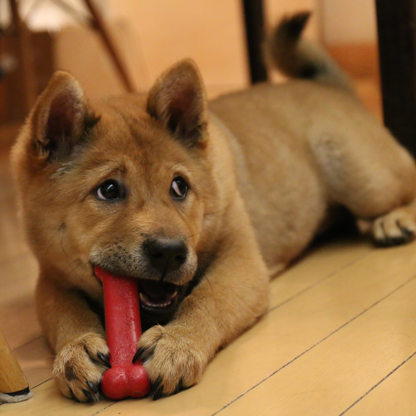

In [123]:
Image.fromarray((x_query.reshape(x_query.shape[1:])*255).astype(np.uint8))

In [156]:
class AdversarialExample:
    def __init__(self,
                 title,
                 image):
        self.title = title
        self.image = image
    
    def streamlit_show(self, 
                       st_container):
        with st_container:
            st.title(self.title)
            st.image(self.image)
        

def draw_images_with_detections(detections_dict):
    colors = list(mcolors.CSS4_COLORS.values())
    images_dict = {}
    width_ratio = 0.2  # Portion of the image the text width should be (between 0 and 1)
    font_family = "arial.ttf"

    for pid, title in enumerate(detections_dict.keys()):
        input_img, detections, model_img_size, classes = detections_dict[title]
#         print((input_img.reshape(x_query.shape[1:])*255).astype(np.uint8))
        input_img = Image.fromarray((input_img.reshape(input_img.shape[1:])*255).astype(np.uint8))
        img_draw_context = ImageDraw.Draw(input_img)
        
        for box in detections:
            xmin = max(int(box[-4] * input_img.size[0]/ model_img_size[1]) , 0)
            ymin = max(int(box[-3] * input_img.size[1]/ model_img_size[1]) , 0)
            xmax = min(int(box[-2] * input_img.size[0]/ model_img_size[1]) , input_img.size[0])
            ymax = min(int(box[-1] * input_img.size[1]/ model_img_size[1]) , input_img.size[1])
            color = colors[int(box[0])]
            label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
            font_size = find_font_size(label, font_family, input_img, width_ratio)
            font = ImageFont.truetype(font_family, font_size)
            img_draw_context.rectangle(xy=[xmin, ymin, xmax, ymax], outline=color, width=4)
            img_draw_context.text(xy=[xmin, ymin], text=label, font=font)
        images_dict[title] = AdversarialExample(title=title, image=input_img)
    return images_dict

In [149]:
fpath = './assets/example_1.jpg'
uploaded_file = Image.open(fpath)
x_query, x_meta = letterbox_image_padded(uploaded_file, size=detector.model_img_size)
detections_query = detector.detect(x_query, conf_threshold=detector.confidence_thresh_default)


In [157]:
# x_adv_fabrication = tog_fabrication(victim=detector, x_query=x_query, n_iter=n_iter, eps=eps, eps_iter=eps_iter)
# x_adv_mislabeling_ml = tog_mislabeling(victim=detector, x_query=x_query, target='ml', n_iter=n_iter, eps=eps, eps_iter=eps_iter)
# x_adv_mislabeling_ll = tog_mislabeling(victim=detector, x_query=x_query, target='ll', n_iter=n_iter, eps=eps, eps_iter=eps_iter)
# x_adv_vanishing = tog_vanishing(victim=detector, x_query=x_query, n_iter=n_iter, eps=eps, eps_iter=eps_iter)
# x_adv_untargeted = tog_untargeted(victim=detector, x_query=x_query, n_iter=n_iter, eps=eps, eps_iter=eps_iter)



# # Visualizing the detection results on the adversarial examples and compare them with that on the benign input
detections_adv_fabrication = detector.detect(x_adv_fabrication, conf_threshold=detector.confidence_thresh_default)
detections_adv_mislabeling_ml = detector.detect(x_adv_mislabeling_ml, conf_threshold=detector.confidence_thresh_default)
detections_adv_mislabeling_ll = detector.detect(x_adv_mislabeling_ll, conf_threshold=detector.confidence_thresh_default)
detections_adv_untargeted = detector.detect(x_adv_untargeted, conf_threshold=detector.confidence_thresh_default)
detections_adv_vanishing = detector.detect(x_adv_vanishing, conf_threshold=detector.confidence_thresh_default)


tab_names = ['Original Image', 
            'Benign (No Attack)', 
            'TOG-fabrication', 
            'TOG-mislabeling (ML)',
            'TOG-mislabeling (LL)',
            'TOG-vanishing',
            'TOG-untargeted']
adversarial_detections_dicts = {tab_names[1]: (x_query, detections_query, detector.model_img_size, detector.classes),
                                tab_names[2]: (x_adv_fabrication, detections_adv_fabrication, detector.model_img_size, detector.classes),
                                tab_names[3]: (x_adv_mislabeling_ml, detections_adv_mislabeling_ml, detector.model_img_size, detector.classes),
                                tab_names[4]: (x_adv_mislabeling_ll, detections_adv_mislabeling_ll, detector.model_img_size, detector.classes),
                                tab_names[5]: (x_adv_vanishing, detections_adv_vanishing, detector.model_img_size, detector.classes),
                                tab_names[6]: (x_adv_untargeted, detections_adv_untargeted, detector.model_img_size, detector.classes)}                                      

drawn_images = draw_images_with_detections(adversarial_detections_dicts)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  # This is added back by InteractiveShellApp.init_path()
/usr

In [160]:
tab_containers = st.tabs(tab_names)
drawn_images_dict = draw_images_with_detections(adversarial_detections_dicts)
drawn_images_dict[tab_names[0]] = AdversarialExample(title=tab_names[0],
                                                         image=uploaded_file)
for i, tab_name in enumerate(tab_names):
    tab_container = tab_containers[i]
    ad_sample = drawn_images_dict[tab_name].streamlit_show(tab_container)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  # This is added back by InteractiveShellApp.init_path()
/usr

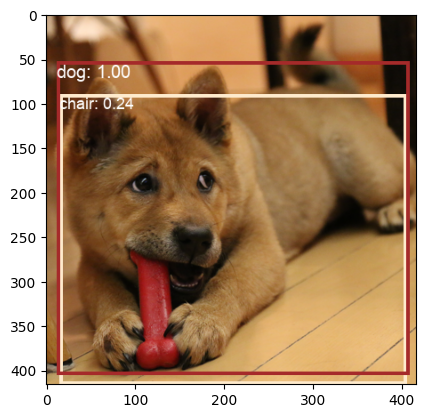

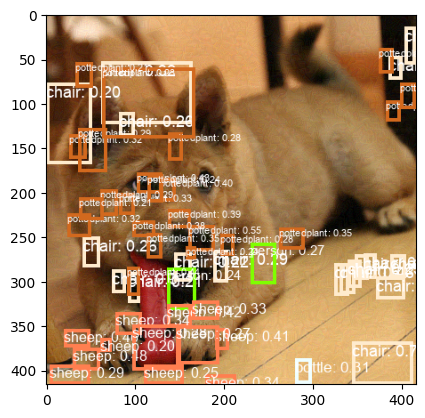

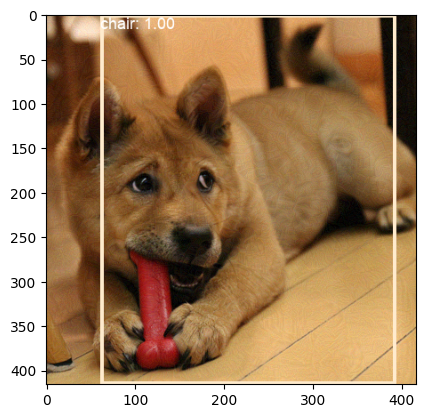

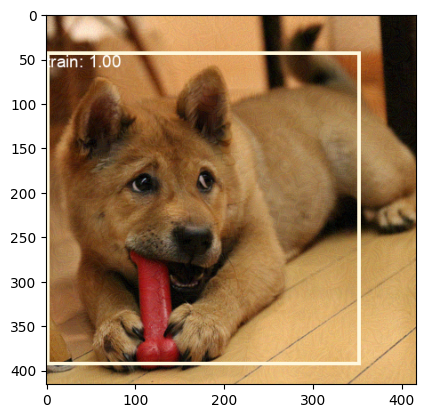

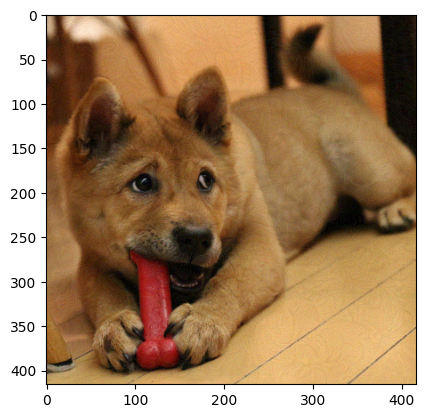

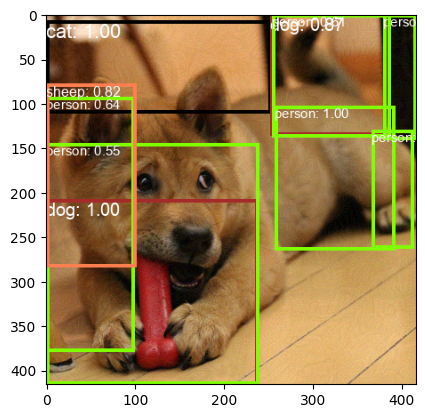

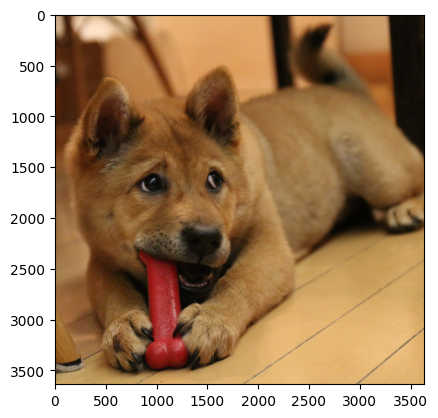

In [162]:
for i in drawn_images_dict.values():
    plt.figure()
    plt.imshow(i.image)

In [ ]:
# Generation of the adversarial examples

# Visualizing the detection results on the adversarial examples and compare them with that on the benign input
visualize_detections({'Benign (No Attack)': (x_query, detections_query, detector.model_img_size, detector.classes),
                      'TOG-mislabeling (ML)': (x_adv_mislabeling_ml, detections_adv_mislabeling_ml, detector.model_img_size, detector.classes),
                      'TOG-mislabeling (LL)': (x_adv_mislabeling_ll, detections_adv_mislabeling_ll, detector.model_img_size, detector.classes)})

In [ ]:
x_adv_fabrication = tog_fabrication(victim=detector, x_query=x_query, n_iter=n_iter, eps=eps, eps_iter=eps_iter)

# Visualizing the detection results on the adversarial example and compare them with that on the benign input
detections_adv_fabrication = detector.detect(x_adv_fabrication, conf_threshold=detector.confidence_thresh_default)
visualize_detections({'Benign (No Attack)': (x_query, detections_query, detector.model_img_size, detector.classes),
                      'TOG-fabrication': (x_adv_fabrication, detections_adv_fabrication, detector.model_img_size, detector.classes)})

In [ ]:
# Generation of the adversarial example
x_adv_vanishing = tog_vanishing(victim=detector, x_query=x_query, n_iter=n_iter, eps=eps, eps_iter=eps_iter)

# Visualizing the detection results on the adversarial example and compare them with that on the benign input
detections_adv_vanishing = detector.detect(x_adv_vanishing, conf_threshold=detector.confidence_thresh_default)
visualize_detections({'Benign (No Attack)': (x_query, detections_query, detector.model_img_size, detector.classes),
                      'TOG-vanishing': (x_adv_vanishing, detections_adv_vanishing, detector.model_img_size, detector.classes)})

In [ ]:
# Generation of the adversarial example
x_adv_untargeted = tog_untargeted(victim=detector, x_query=x_query, n_iter=n_iter, eps=eps, eps_iter=eps_iter)

# Visualizing the detection results on the adversarial example and compare them with that on the benign input
detections_adv_untargeted = detector.detect(x_adv_untargeted, conf_threshold=detector.confidence_thresh_default)
visualize_detections({'Benign (No Attack)': (x_query, detections_query, detector.model_img_size, detector.classes),
                      'TOG-untargeted': (x_adv_untargeted, detections_adv_untargeted, detector.model_img_size, detector.classes)})